## CRISP-DM Phase 4. Modelling

In this phase, various modeling techniques are selected and applied, and their parameters are calibrated to optimal values. Typically, there are several techniques for the same data mining problem type. Some techniques have specific requirements on the form of data. Therefore, going back to the data preparation phase is often necessary.

In [83]:
# Dependencies
import sys
sys.path.append('../src')
import utils
import data_processor
import cross_validator
import model
import pandas as pd
import numpy as np
from numpy import argmax
import matplotlib.pyplot as plt
import pickle as pkl
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from xgboost import XGBClassifier
import warnings 
warnings.filterwarnings('ignore')

# Load processed data
data: pd.DataFrame = utils.load_preprocessed_data("../data/processed/financial_data_processed_sampled.pkl")

# Data preprocessing object
processor = data_processor.DataProcessor(data)
X, y = processor.create_feature_matrix_and_target_vector(target_column="Financial Distress")

In [76]:
# Train-test split (70-30) without shuffling (preserve time order)
X_train, _ , y_train, _ = train_test_split(X, y, test_size=0.3, shuffle=False)

# TimeSeriesCrossValidator object 
# The testing set is preserved for evaluating the best model evaluated by cross-validation. 
tscv = cross_validator.TimeSeriesCrossValidator(X_train, y_train)

### Model Building

In [77]:
models = [RandomForestClassifier(), SVC(), KNeighborsClassifier(), LogisticRegression(), xgb.XGBClassifier(), AdaBoostClassifier(), GaussianNB()]


# Evaluate models using TimeSeriesCrossValidator
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
auc_list = []
model_names = []

for model in models:
    accuracy, precision, recall, f1, auc_score = tscv.evaluate(model, return_model=False)
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    auc_list.append(auc_score)
    model_names.append(model.__class__.__name__)

# Create dataframe with all metrics
metrics_df = pd.DataFrame({'Model': model_names, 'Accuracy': accuracy_list, 'Precision': precision_list, 'Recall': recall_list, 'F1': f1_list, 'ROC_AUC': auc_list})
metrics_df

,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,RandomForestClassifier,"[0.9493927125506073, 0.9321266968325792, 0.937...","[0.9347826086956522, 0.8717948717948718, 0.896...","[0.9297297297297298, 0.9315068493150684, 0.916...","[0.932249322493225, 0.9006622516556291, 0.9063...","[0.9454473891367096, 0.9319696408737504, 0.932..."
1,SVC,"[0.9089068825910931, 0.9479638009049773, 0.939...","[0.8763440860215054, 0.89171974522293, 0.88028...","[0.8810810810810811, 0.958904109589041, 0.9469...","[0.8787061994609164, 0.9240924092409241, 0.912...","[0.903323712061576, 0.9507358385783042, 0.9416..."
2,KNeighborsClassifier,"[0.8927125506072875, 0.9276018099547512, 0.934...","[0.8142857142857143, 0.8433734939759037, 0.844...","[0.9243243243243243, 0.958904109589041, 0.9848...","[0.8658227848101265, 0.8974358974358975, 0.909...","[0.8990553660456573, 0.9355331358756016, 0.947..."
3,LogisticRegression,"[0.8906882591093117, 0.9140271493212669, 0.917...","[0.8502673796791443, 0.8506493506493507, 0.851...","[0.8594594594594595, 0.8972602739726028, 0.909...","[0.8548387096774193, 0.8733333333333334, 0.879...","[0.8844222863640339, 0.90977878563495, 0.91521..."
4,XGBClassifier,"[0.9392712550607287, 0.9502262443438914, 0.939...","[0.91005291005291, 0.9078947368421053, 0.89705...","[0.9297297297297298, 0.9452054794520548, 0.924...","[0.9197860962566844, 0.9261744966442953, 0.910...","[0.9373567742499782, 0.9489540910773788, 0.935..."
5,AdaBoostClassifier,"[0.937246963562753, 0.9343891402714932, 0.9147...","[0.9139784946236559, 0.8926174496644296, 0.855...","[0.918918918918919, 0.910958904109589, 0.89393...","[0.9164420485175202, 0.9016949152542374, 0.874...","[0.933569491821919, 0.9284524250277674, 0.9095..."
6,GaussianNB,"[0.7854251012145749, 0.6538461538461539, 0.634...","[0.6479400749063671, 0.4874551971326165, 0.474...","[0.9351351351351351, 0.9315068493150684, 0.969...","[0.7654867256637169, 0.64, 0.6368159203980099,...","[0.8154640076970174, 0.7241993706034802, 0.718..."


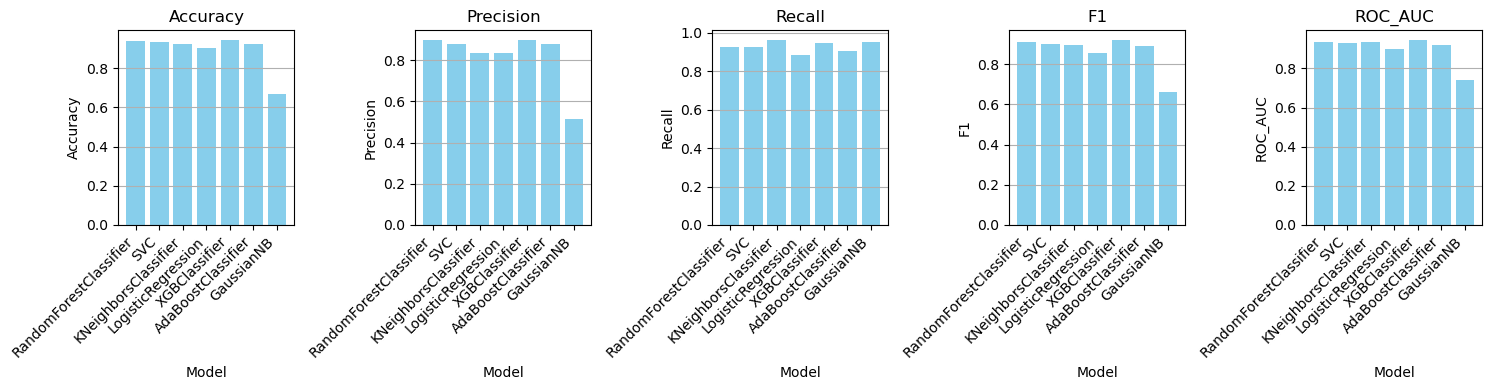

In [78]:
# Create subplots for each metric
fig, axes = plt.subplots(1, 5, figsize=(15, 4))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC']

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.bar(metrics_df['Model'], metrics_df[metric].apply(lambda x: np.mean(x)), color='skyblue')
    ax.set_title(metric)
    ax.set_xlabel('Model')
    ax.set_ylabel(metric)
    ax.set_xticklabels(metrics_df['Model'], rotation=45, ha='right')
    ax.yaxis.grid()

# Adjust the layout to avoid overlapping titles
plt.tight_layout()

# Save the plot
plt.savefig('../plots/metrics_mean.png')

# Show the plot
plt.show()

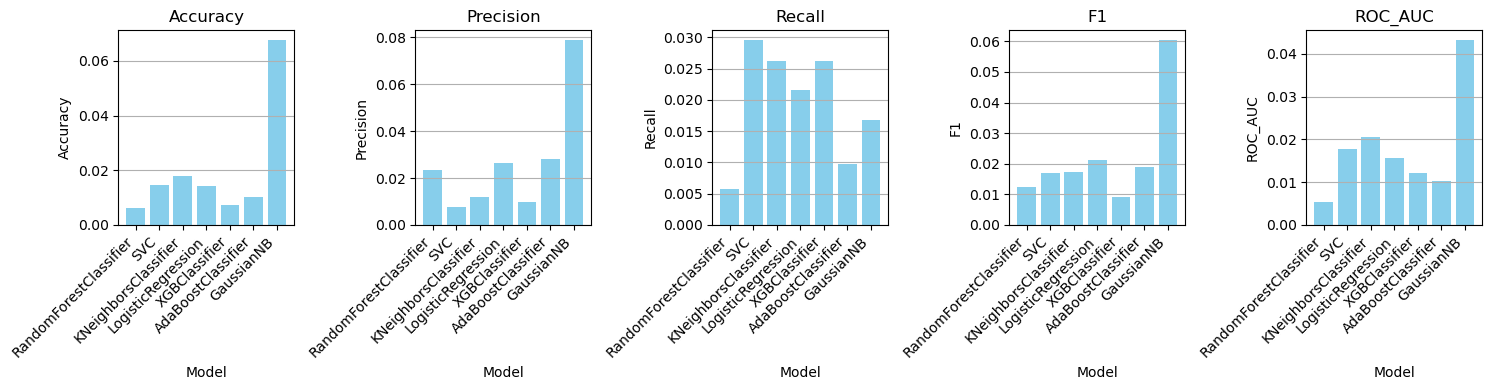

In [79]:
# plot standard deviation of each metric
fig, axes = plt.subplots(1, 5, figsize=(15, 4))

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.bar(metrics_df['Model'], metrics_df[metric].apply(lambda x: np.std(x)), color='skyblue')
    ax.set_title(metric)
    ax.set_xlabel('Model')
    ax.set_ylabel(metric)
    ax.set_xticklabels(metrics_df['Model'], rotation=45, ha='right')
    ax.yaxis.grid()

# Adjust the layout to avoid overlapping titles
plt.tight_layout()

# Save the plot
plt.savefig('../plots/metrics_std.png')

# Show the plot
plt.show()

- Accuracy, F1 and AUC-ROC scores are similar for all models, with the exception of GaussianNB which seems to perform worse than the other models.
- However, analysing the standard deviation of each metric, we can see that XGBoost and AdaBoost have the lowest standard deviation for almost all metrics, indicating that they are the most stable models.

### Analyzing XGBoost and Adaboost with ROC Curves and Precision-Recall Curves

In imbalanced datasets, where the number of instances in the positive class is much smaller than the negative class, accuracy can be misleading. Precision and recall become crucial metrics in such scenarios, as they provide insights into the model's ability to correctly identify instances of the positive class.

I will explore ROC curve, despite it being less sensitive to imbalanced datasets, and Precision-Recall which is more suitable to address the challenges of imbalanced classes.

In [86]:
# split X_train into train and validation sets (80-20)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

xgb = XGBClassifier()
adaboost = AdaBoostClassifier()
# fit models
xgb.fit(X_train, y_train) 
adaboost.fit(X_train, y_train)

# predict probabilities
lr_probs_xgb = xgb.predict_proba(X_val)
lr_probs_adaboost = adaboost.predict_proba(X_val)

#### ROC Curves

Naive: ROC AUC=0.500
XGBoost: ROC AUC=0.986
AdaBoost: ROC AUC=0.959


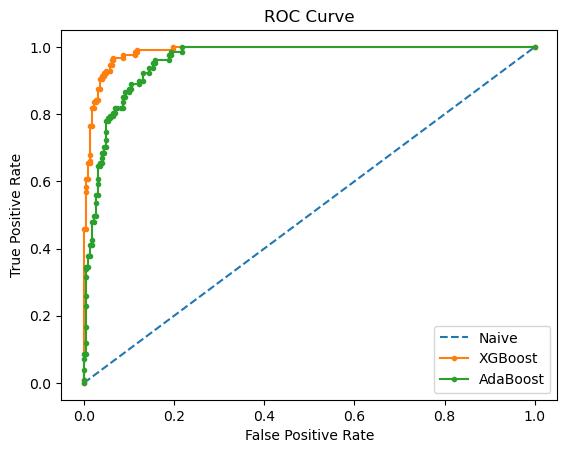

In [87]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_val))]
# keep probabilities for the positive outcome only
lr_probs_xgb = lr_probs_xgb[:, 1]
lr_probs_adaboost = lr_probs_adaboost[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_val, ns_probs)
lr_auc_xgb = roc_auc_score(y_val, lr_probs_xgb)
lr_auc_adaboost = roc_auc_score(y_val, lr_probs_adaboost)
# summarize scores
print('Naive: ROC AUC=%.3f' % (ns_auc))
print('XGBoost: ROC AUC=%.3f' % (lr_auc_xgb))
print('AdaBoost: ROC AUC=%.3f' % (lr_auc_adaboost))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_val, ns_probs)
lr_fpr_xgb, lr_tpr_xgb, _ = roc_curve(y_val, lr_probs_xgb)
lr_fpr_adaboost, lr_tpr_adaboost, _ = roc_curve(y_val, lr_probs_adaboost)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Naive')
plt.plot(lr_fpr_xgb, lr_tpr_xgb, marker='.', label='XGBoost')
plt.plot(lr_fpr_adaboost, lr_tpr_adaboost, marker='.', label='AdaBoost')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# Title 
plt.title('ROC Curve')
# show the plot
plt.savefig('../plots/roc_curve.png')
plt.show()

- A naive classifier is one that cannot discriminate between the classes and would predict a random class or a constant class in all cases. A naive model at each threshold is represented by a diagonal line from the bottom left of the plot to the top right and has an AUC of 0.5.

- A model with perfect skill is represented at a point (0,1). A model with perfect skill is represented by a line that travels from the bottom left of the plot to the top left and then across the top to the top right.

#### Precision-Recall Curves

- Reviewing both precision and recall is useful in cases where there is an imbalance in the observations between the two classes. Specifically, when there are many instances of no event (class 0) and only a few examples of an event (class 1) which is the case of this dataset.
- Key to the calculation of precision and recall is that the calculations do not make use of the true negatives. It is only concerned with the correct prediction of the minority class (class 1).
- A precision-recall curve is a plot of the precision (y-axis) and the recall (x-axis) for different probability thresholds, much like the ROC curve.
- A naive classifier is one that cannot discriminate between the classes and would predict a random class or a constant class in all cases. The naive model's line changes based on the distribution of the positive to negative classes. It is a horizontal line with the value of the ratio of positive cases in the dataset. For a balanced dataset, this is 0.5.
- In terms of model selection, F-Measure summarizes model skill for a specific probability threshold (e.g. 0.5), whereas the area under curve summarize the skill of a model across thresholds, like ROC AUC.

**In imbalanced settings, AUC-PR can provide a more nuanced view of model performance, particularly in capturing positive instances.**

XGBoost: f1=0.902 auc_PRC=0.974
AdaBoost: f1=0.831 auc_PRC=0.912


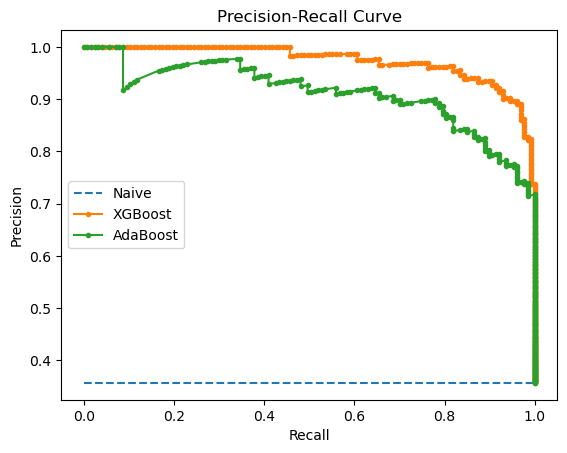

In [88]:
# predict probabilities
xgb_probs = xgb.predict_proba(X_val)
adaboost_probs = adaboost.predict_proba(X_val)

# keep probabilities for the positive outcome only
xgb_probs = xgb_probs[:, 1]
adaboost_probs = adaboost_probs[:, 1]

# predict class values
yhat_xgb = xgb.predict(X_val)
yhat_adaboost = adaboost.predict(X_val)

# calculate precision and recall for each threshold
xgb_precision, xgb_recall, _ = precision_recall_curve(y_val, xgb_probs)
adaboost_precision, adaboost_recall, _ = precision_recall_curve(y_val, adaboost_probs)

# calculate scores
xgb_f1, xgb_auc = f1_score(y_val, yhat_xgb), auc(xgb_recall, xgb_precision)
adaboost_f1, adaboost_auc = f1_score(y_val, yhat_adaboost), auc(adaboost_recall, adaboost_precision)

# summarize scores
print('XGBoost: f1=%.3f auc_PRC=%.3f' % (xgb_f1, xgb_auc))
print('AdaBoost: f1=%.3f auc_PRC=%.3f' % (adaboost_f1, adaboost_auc))

# plot the precision-recall curves
naive = len(y_val[y_val==1]) / len(y_val)
plt.plot([0, 1], [naive, naive], linestyle='--', label='Naive')
plt.plot(xgb_recall, xgb_precision, marker='.', label='XGBoost')
plt.plot(adaboost_recall, adaboost_precision, marker='.', label='AdaBoost')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# Title
plt.title('Precision-Recall Curve')
# show the legend
plt.legend()
# show the plot
plt.show()

- F1 score is a metric that considers both precision and recall, providing a balance between false positives and false negatives.t is especially useful when you have imbalanced classes because it gives equal weight to false positives and false negatives.
- AUC-ROC measures the ability of a model to distinguish between positive and negative instances. A higher AUC-ROC indicates a better ability to discriminate between the positive and negative classes.
- If the primary concern is achieving a balance between precision and recall, XGBoost might be a better choice due to its higher F1 score.
If the focus is on the overall ability to discriminate between positive and negative instances, AdaBoost has a higher AUC-ROC, indicating better discriminatory power.
- **In light of this information, and respecting the business understanding section, f-score should be employed as a primary performance evaluation criterion, resulting in the XGBoost's selection, the model with the highest f-score.**

#### Threshold-Tuning for Imbalanced Classification

- I will determine the Optimal Threshold for the Precision-Recall Curve: precision-recall curve focuses on the performance of a classifier on the positive (minority class) only (describes how good a model is at predicting the positive class[Distresses Company]).
- Because this threshold results in the best balance of precision and recall, this is the same as optimizing the F-measure that summarizes the harmonic mean of both measures.

Best Threshold=0.113677, F-Score=0.928


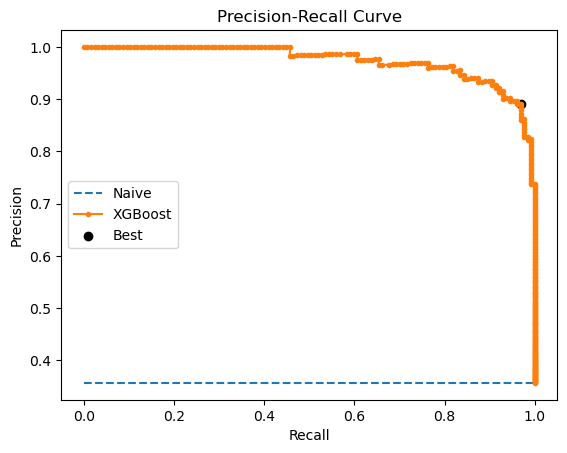

In [90]:
# predict probabilities
xgb_probs = xgb.predict_proba(X_val)

# keep probabilities for the positive outcome only
xgb_probs = xgb_probs[:, 1]

# predict class values
yhat_xgb = xgb.predict(X_val)
yhat_adaboost = adaboost.predict(X_val)

# calculate precision and recall for each threshold
xgb_precision, xgb_recall, thresholds = precision_recall_curve(y_val, xgb_probs)

# convert to f score
fscore = (2 * xgb_precision * xgb_recall) / (xgb_precision + xgb_recall)
# locate the index of the largest f score
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

# plot the precision-recall curves
naive = len(y_val[y_val==1]) / len(y_val)
plt.plot([0, 1], [naive, naive], linestyle='--', label='Naive')
plt.plot(xgb_recall, xgb_precision, marker='.', label='XGBoost')
plt.scatter(xgb_recall[ix], xgb_precision[ix], marker='o', color='black', label='Best')

# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# Title
plt.title('Precision-Recall Curve')
# show the legend
plt.legend()
# show the plot
plt.show()

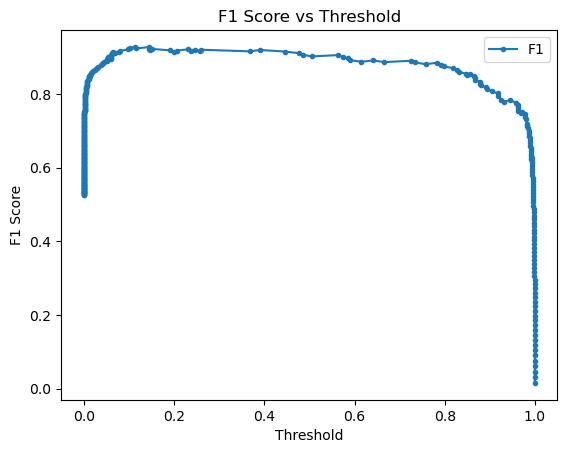

In [91]:
# thresholds: probability thresholds for the positive class (1) - Financial Distress

# plot threshold line
plt.plot(thresholds, fscore[:-1], marker='.', label='F1')
# axis labels
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
# Title
plt.title('F1 Score vs Threshold')
# show the legend
plt.legend()
plt.show()

### Save Best Model

In [92]:
# save model
pkl.dump(xgb, open('../artifacts/xgb.pkl', 'wb'))